In [178]:

import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp
from genpen.utils import Paper
from scipy import stats
import geopandas
from shapely.errors import TopologicalError
import functools
import vpype
from skimage import io
from pathlib import Path

from sklearn.preprocessing import minmax_scale
from skimage import feature
from skimage import exposure
from torch import Tensor
from torch import nn
from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk
from numpy.random import default_rng


from PIL import Image
import attr

import cv2
from rasterio import features
import rasterio
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pydiffvg as dg
import torch
import skimage
import numpy as np
from torchvision.transforms import functional as TF
from IPython import display
from copy import deepcopy
import fn
import torch.nn.functional as F

In [1544]:
import torch
import contextlib

# https://github.com/aliutkus/torchinterp1d/blob/master/torchinterp1d/interp1d.py

class Interp1d(torch.autograd.Function):
    def __call__(self, x, y, xnew, out=None):
        return self.forward(x, y, xnew, out)

    def forward(ctx, x, y, xnew, out=None):
        """
        Linear 1D interpolation on the GPU for Pytorch.
        This function returns interpolated values of a set of 1-D functions at
        the desired query points `xnew`.
        This function is working similarly to Matlab™ or scipy functions with
        the `linear` interpolation mode on, except that it parallelises over
        any number of desired interpolation problems.
        The code will run on GPU if all the tensors provided are on a cuda
        device.
        Parameters
        ----------
        x : (N, ) or (D, N) Pytorch Tensor
            A 1-D or 2-D tensor of real values.
        y : (N,) or (D, N) Pytorch Tensor
            A 1-D or 2-D tensor of real values. The length of `y` along its
            last dimension must be the same as that of `x`
        xnew : (P,) or (D, P) Pytorch Tensor
            A 1-D or 2-D tensor of real values. `xnew` can only be 1-D if
            _both_ `x` and `y` are 1-D. Otherwise, its length along the first
            dimension must be the same as that of whichever `x` and `y` is 2-D.
        out : Pytorch Tensor, same shape as `xnew`
            Tensor for the output. If None: allocated automatically.
        """
        # making the vectors at least 2D
        is_flat = {}
        require_grad = {}
        v = {}
        device = []
        eps = torch.finfo(y.dtype).eps
        for name, vec in {'x': x, 'y': y, 'xnew': xnew}.items():
            assert len(vec.shape) <= 2, 'interp1d: all inputs must be '\
                                        'at most 2-D.'
            if len(vec.shape) == 1:
                v[name] = vec[None, :]
            else:
                v[name] = vec
            is_flat[name] = v[name].shape[0] == 1
            require_grad[name] = vec.requires_grad
            device = list(set(device + [str(vec.device)]))
        assert len(device) == 1, 'All parameters must be on the same device.'
        device = device[0]

        # Checking for the dimensions
        assert (v['x'].shape[1] == v['y'].shape[1]
                and (
                     v['x'].shape[0] == v['y'].shape[0]
                     or v['x'].shape[0] == 1
                     or v['y'].shape[0] == 1
                    )
                ), ("x and y must have the same number of columns, and either "
                    "the same number of row or one of them having only one "
                    "row.")

        reshaped_xnew = False
        if ((v['x'].shape[0] == 1) and (v['y'].shape[0] == 1)
           and (v['xnew'].shape[0] > 1)):
            # if there is only one row for both x and y, there is no need to
            # loop over the rows of xnew because they will all have to face the
            # same interpolation problem. We should just stack them together to
            # call interp1d and put them back in place afterwards.
            original_xnew_shape = v['xnew'].shape
            v['xnew'] = v['xnew'].contiguous().view(1, -1)
            reshaped_xnew = True

        # identify the dimensions of output and check if the one provided is ok
        D = max(v['x'].shape[0], v['xnew'].shape[0])
        shape_ynew = (D, v['xnew'].shape[-1])
        if out is not None:
            if out.numel() != shape_ynew[0]*shape_ynew[1]:
                # The output provided is of incorrect shape.
                # Going for a new one
                out = None
            else:
                ynew = out.reshape(shape_ynew)
        if out is None:
            ynew = torch.zeros(*shape_ynew, device=device)

        # moving everything to the desired device in case it was not there
        # already (not handling the case things do not fit entirely, user will
        # do it if required.)
        for name in v:
            v[name] = v[name].to(device)

        # calling searchsorted on the x values.
        ind = ynew.long()

        # expanding xnew to match the number of rows of x in case only one xnew is
        # provided
        if v['xnew'].shape[0] == 1:
            v['xnew'] = v['xnew'].expand(v['x'].shape[0], -1)

        torch.searchsorted(v['x'].contiguous(),
                           v['xnew'].contiguous(), out=ind)

        # the `-1` is because searchsorted looks for the index where the values
        # must be inserted to preserve order. And we want the index of the
        # preceeding value.
        ind -= 1
        # we clamp the index, because the number of intervals is x.shape-1,
        # and the left neighbour should hence be at most number of intervals
        # -1, i.e. number of columns in x -2
        ind = torch.clamp(ind, 0, v['x'].shape[1] - 1 - 1)

        # helper function to select stuff according to the found indices.
        def sel(name):
            if is_flat[name]:
                return v[name].contiguous().view(-1)[ind]
            return torch.gather(v[name], 1, ind)

        # activating gradient storing for everything now
        enable_grad = False
        saved_inputs = []
        for name in ['x', 'y', 'xnew']:
            if require_grad[name]:
                enable_grad = True
                saved_inputs += [v[name]]
            else:
                saved_inputs += [None, ]
        # assuming x are sorted in the dimension 1, computing the slopes for
        # the segments
        is_flat['slopes'] = is_flat['x']
        # now we have found the indices of the neighbors, we start building the
        # output. Hence, we start also activating gradient tracking
        with torch.enable_grad() if enable_grad else contextlib.suppress():
            v['slopes'] = (
                    (v['y'][:, 1:]-v['y'][:, :-1])
                    /
                    (eps + (v['x'][:, 1:]-v['x'][:, :-1]))
                )

            # now build the linear interpolation
            ynew = sel('y') + sel('slopes')*(
                                    v['xnew'] - sel('x'))

            if reshaped_xnew:
                ynew = ynew.view(original_xnew_shape)

        ctx.save_for_backward(ynew, *saved_inputs)
        return ynew

    @staticmethod
    def backward(ctx, grad_out):
        inputs = ctx.saved_tensors[1:]
        gradients = torch.autograd.grad(
                        ctx.saved_tensors[0],
                        [i for i in inputs if i is not None],
                        grad_out, retain_graph=True)
        result = [None, ] * 5
        pos = 0
        for index in range(len(inputs)):
            if inputs[index] is not None:
                result[index] = gradients[pos]
                pos += 1
        return (*result,)

In [17]:
def finalize_image(img, gamma = 2.2, normalize = False, as_Image=False):
    if not isinstance(img, np.ndarray):
        img = img.data.numpy()
    if normalize:
        img_rng = np.max(img) - np.min(img)
        if img_rng > 0:
            img = (img - np.min(img)) / img_rng
    img = np.clip(img, 0.0, 1.0)
    if img.ndim==2:
        #repeat along the third dimension
        img=np.expand_dims(img,2)
    img[:, :, :3] = np.power(img[:, :, :3], 1.0/gamma)
    img = (img * 255).astype(np.uint8)
    if as_Image:
        img = Image.fromarray(img)
    return img

In [18]:
class LineTensor(object):
    
    def __init__(
        self,
        linestring,
    ):
        self.init_ls = linestring
        self.pts = [p for p in self.init_ls.coords]
        self.tensor = torch.tensor(self.pts, requires_grad=True)
        self.init_loc_pt = self.ls.centroid
        self.init_loc_tensor = torch.tensor(np.array(self.init_loc_pt), requires_grad=True)
        
    @property
    def ls(self):
        return LineString(self.tensor.cpu().data.numpy())

# diffvg

In [19]:
# Use GPU if available
dg.set_use_gpu(torch.cuda.is_available())

In [20]:
width = 1200
height = 1600
drawbox = box(0, 0, width, height)
db = gp.Shape(drawbox)

In [9]:
drawbox = box(0, 0, width, height)
db = gp.Shape(drawbox)

In [10]:
out_shape = np.array((db.height, db.width)).round().astype(int)

In [11]:
nft_id = fn.new_nft_id()

raster_videos_dir = Path('/home/naka/art/raster_videos')
nft_dir = raster_videos_dir.joinpath(nft_id)

if not nft_dir.exists():
    os.mkdir(nft_dir) 
    

saved 20220115-073536_482422-08f81-7e6a58 to s3://algorithmic-ink/current_nft_id


# single

In [24]:
Point()

In [215]:
@attr.define()
class CircleP(object):
    center: Tensor = Tensor((0., 0.))
    radius: Tensor = Tensor((1.,))
    stroke_width: Tensor = Tensor((1.,))
    color: Tensor = Tensor((1., 1., 1., 1.))
    
    
    def requires_grad(self, requires_grad=True):
        self.center.requires_grad = requires_grad
        self.radius.requires_grad = requires_grad
        self.stroke_width.requires_grad = requires_grad
        self.color.requires_grad = requires_grad
        return self

In [2130]:
CANVAS_WIDTH = 800
CANVAS_HEIGHT = 800
DRAW_WHITE_BACKGROUND = False

In [2131]:
def render_circles(cc, multiplier=1):
    """Render circles to image.

    Args:
      centers: points defining the lines
      stroke_widths: the widths of the lines
      all_colors: line colours
      multiplier: scale factor to enlarge drawing

    Returns:
      image with lines drawn
    """
    # Store `centers` definitions as shapes, colours and widths.
    shapes = []
    shape_groups = []
    for c in cc:
      center = c.center.contiguous().cpu()
      radius = c.radius.cpu()
      width = c.stroke_width.cpu()
      color = c.color.cpu()
      path = dg.Circle(
          radius=radius*multiplier, 
          center=center * multiplier,
          stroke_width=width * multiplier
          )
      shapes.append(path)
      path_group = dg.ShapeGroup(
          shape_ids=torch.tensor([len(shapes) - 1]),
          fill_color=None,
          stroke_color=color)
      shape_groups.append(path_group)

    # Rasterize the image.
    scene_args = dg.RenderFunction.serialize_scene(
        CANVAS_WIDTH * multiplier,
        CANVAS_HEIGHT * multiplier,
        shapes, shape_groups)
    img = dg.RenderFunction.apply(
        CANVAS_WIDTH * multiplier,
        CANVAS_HEIGHT * multiplier,
        2, 2, 0, None, *scene_args)
    if DRAW_WHITE_BACKGROUND:
      w, h = img.shape[0], img.shape[1]
      img = img[:, :, 3:4] * img[:, :, :3] + (
          torch.ones(w, h, 3, device=dg.get_device()) * (1-img[:, :, 3:4]))
    else:
      img = img[:, :, :3]
    img = img.unsqueeze(0)

    return img

In [2132]:
def to_pil(img):
    return TF.to_pil_image(img.detach().cpu().squeeze().permute(2, 0, 1))

In [2133]:
class CircleCollection(nn.Module):
    
    def __init__(self, centers, radii, stroke_widths, colors):
        super().__init__()
        self.centers = centers
        self.radii = radii
        self.stroke_widths = stroke_widths
        self.colors = colors
        
    @classmethod
    def from_arrays(cls, centers, radii, stroke_widths, colors):
        centers = torch.tensor(centers, requires_grad=True)
        radii = torch.tensor(radii, requires_grad=True)
        stroke_widths = torch.tensor(stroke_widths, requires_grad=True)
        colors = torch.tensor(colors, requires_grad=True)
        return cls(centers, radii, stroke_widths, colors)
        
    @property
    def n_circles(self):
        return self.centers.shape[0]
    
    def requires_grad(self, requires_grad=True):
        self.centers.requires_grad = requires_grad
        self.radii.requires_grad = requires_grad
        self.stroke_widths.requires_grad = requires_grad
        self.colors.requires_grad = requires_grad
        return self
    
    def __getitem__(self, ii):
        return CircleP(self.centers[ii], self.radii[ii], self.stroke_widths[ii], self.colors[ii])
    
    def __iter__(self):
        for ii in range(self.n_circles):
            yield self[ii]
        
    def to_circle_ps(self):
        circle_ps = []
        for ii in range(self.centers.shape[0]):
            circle_ps.append(CircleP(
                center=self.centers[ii],
                radius=self.radii[ii],
                stroke_width=self.stroke_widths[ii],
                color=self.colors[ii]
            ))
        return circle_ps
        

In [2134]:
stats.beta(a=1, b=3).rvs()

0.5043072687557194

In [2135]:
n_outputs = n_circles

In [2136]:
def LazyRelu(input_size):
    return nn.Sequential(
        nn.LazyLinear(input_size),
        nn.ReLU(),
    )
    
def LazyHardsigmoid(input_size):
    return nn.Sequential(
        nn.LazyLinear(input_size),
        nn.Hardsigmoid(),
    )
    
def LazyTanh(input_size):
    return nn.Sequential(
        nn.LazyLinear(input_size),
        nn.Tanh(),
    )

In [2137]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [2488]:
class CircleNet(nn.Module):
    
    
    def __init__(
        self, 
        n_circles,
        x_range,
        y_range,
        rad_range,
        init_centers=None,
        init_radii=None,
        ):
        super().__init__()
        self.n_circles = n_circles
        self.xmin, self.xmax = x_range
        self.ymin, self.ymax = y_range
        self.radmin, self.radmax = rad_range
        
        if init_centers is None:
            xs = torch.rand(n_circles, 1) * (self.xmax - self.xmin) + self.xmin
            ys = torch.rand(n_circles, 1) * (self.ymax - self.ymin) + self.ymin
            init_centers = torch.cat([xs, ys], axis=1)
        self.init_centers = init_centers
        
        if init_radii is None:
            init_radii = torch.rand(n_circles) * (self.radmax - self.radmin) + self.radmin
        self.init_radii = init_radii
        
        self.net =nn.Sequential(
            nn.Linear(0, 128),
            nn.ReLU(),
            LazyRelu(128),
            LazyRelu(128),
            LazyRelu(128),
        )
        
        
        self.x_outputs = LazyTanh(self.n_circles)
        self.y_outputs = LazyTanh(self.n_circles)
        self.radius_outputs = LazyTanh(self.n_circles)
        
        
    def initialize_weights(self):
        self.forward()
        self.net.apply(init_weights)
        self.x_outputs.apply(init_weights)
        self.y_outputs.apply(init_weights)
        self.radius_outputs.apply(init_weights)
        
    def get_net_output(self):
        return self.net(Tensor())
        
    def get_radii(self, x):
        return self.radius_outputs(x) * (self.radmax - self.radmin) * 0.5 + self.init_radii
    
    def get_xs(self, x):
        return self.x_outputs(x).unsqueeze(1) * (self.xmax - self.xmin) * 0.5
    
    def get_ys(self, x):
        return self.y_outputs(x).unsqueeze(1) * (self.ymax - self.ymin) * 0.5 
    
    def get_centers(self, x):
        return torch.cat([self.get_xs(x), self.get_ys(x)], axis=1) + self.init_centers
    
    def forward(self):
        x = self.get_net_output()
        centers = self.get_centers(x)
        radii = self.get_radii(x)
        colors = torch.ones((self.n_circles,4))
        stroke_widths = torch.ones((self.n_circles,1)) * 0.4

        cc = CircleCollection(centers=centers, radii=radii, stroke_widths=stroke_widths, colors=colors)
        return cc
        

/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
<ipython-input-2137-f9c2b1da9c33>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


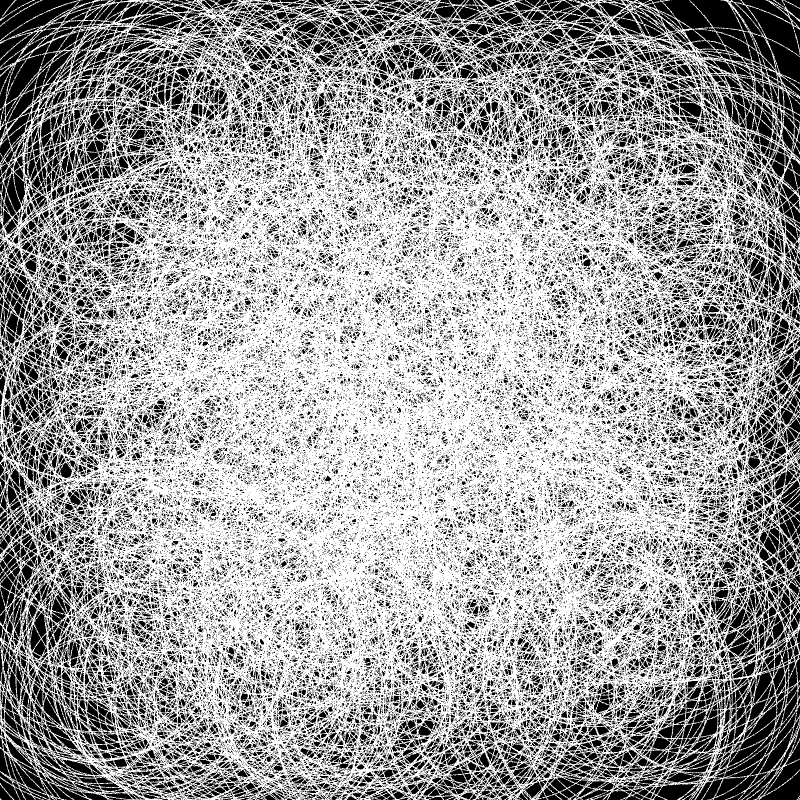

In [2489]:
n_circles = 1500
rad_range = (0.1,450)
x_range = (CANVAS_WIDTH*0.1, CANVAS_WIDTH*0.9)
y_range = (CANVAS_HEIGHT*0.1, CANVAS_HEIGHT*0.9)

xs = torch.rand(n_circles, 1) * (x_range[1] - x_range[0])  + x_range[0] 
ys = torch.rand(n_circles, 1) * (y_range[1] - y_range[0]) + y_range[0]
init_centers = torch.cat([xs, ys], axis=1)

init_radii = torch.rand(n_circles) * 200 + 1

model = CircleNet(
    n_circles=n_circles,
    x_range=x_range,
    y_range=y_range,
    rad_range=rad_range,
    init_centers=init_centers,
    init_radii=init_radii,
 
 )
model.initialize_weights()
cc = model.forward()
img = render_circles(cc)
to_pil(img)

In [2490]:
def train(loss_weights=None):
    
    cc = model.forward()
    
    if loss_weights is None:
        loss_weights = {
            'big_rad_loss': 1,
            'overlap_loss': 1,
            'distance_loss': 1,
            'out_of_bounds_loss': 1,
            
        }
    optim.zero_grad()
    losses = {}
    overlap_buffer = 0

    # desired rad size
    # target_rad_loss = (target_radius - cc.radii).pow(2).sum()
    
    # big rad 
    losses['big_rad_loss'] = (-cc.radii).exp().sum()

    # prevent overlap
    dists = torch.cdist(cc.centers, cc.centers)
    upper_dists = torch.triu(dists)
    nonzero_inds = torch.nonzero(upper_dists, as_tuple=True)
    dists[nonzero_inds]
    summed_rads = cc.radii.unsqueeze(0).T + cc.radii.unsqueeze(0)
    edge_to_edge_dists = dists[nonzero_inds] - summed_rads[nonzero_inds] - overlap_buffer
    losses['overlap_loss'] = F.relu(-edge_to_edge_dists).pow(3).sum()
    losses['distance_loss'] = edge_to_edge_dists.pow(2).sum()

    # out of bounds
    xs = cc.centers[:, 0]
    ys = cc.centers[:, 1]
    left_edge_dist = F.relu(-((xs - cc.radii) - xmin))
    right_edge_dist = F.relu(-((xmax - (xs + cc.radii))))
    bottom_edge_dist = F.relu(-((ys - cc.radii) - ymin))
    top_edge_dist = F.relu(-(ymax - (ys + cc.radii)))
    losses['out_of_bounds_loss'] = (left_edge_dist + right_edge_dist + bottom_edge_dist + top_edge_dist).pow(2).sum()
    
    #maximize skewnewss
    # losses['skewness_loss'] = -(moment(cc.radii, n=3).pow(2))
    # losses['variance_loss'] = -(moment(cc.radii, n=2).pow(2))

    scaled_losses = {key: loss*loss_weights[key] for key, loss in losses.items()}
    loss = sum(scaled_losses.values())

    loss.backward()
    optim.step()
    
    scaled_losses['loss'] = loss
    return losses, scaled_losses, cc

In [2491]:

optim = torch.optim.Adam(model.parameters(), lr=1e-4)


In [2492]:
nft_id = fn.new_nft_id()

raster_videos_dir = Path('/home/naka/art/raster_videos')
nft_dir = raster_videos_dir.joinpath(nft_id)

if not nft_dir.exists():
    os.mkdir(nft_dir) 
    
frame_counter = 0

saved 20220115-152135_807294-08f81-a0a461 to s3://algorithmic-ink/current_nft_id


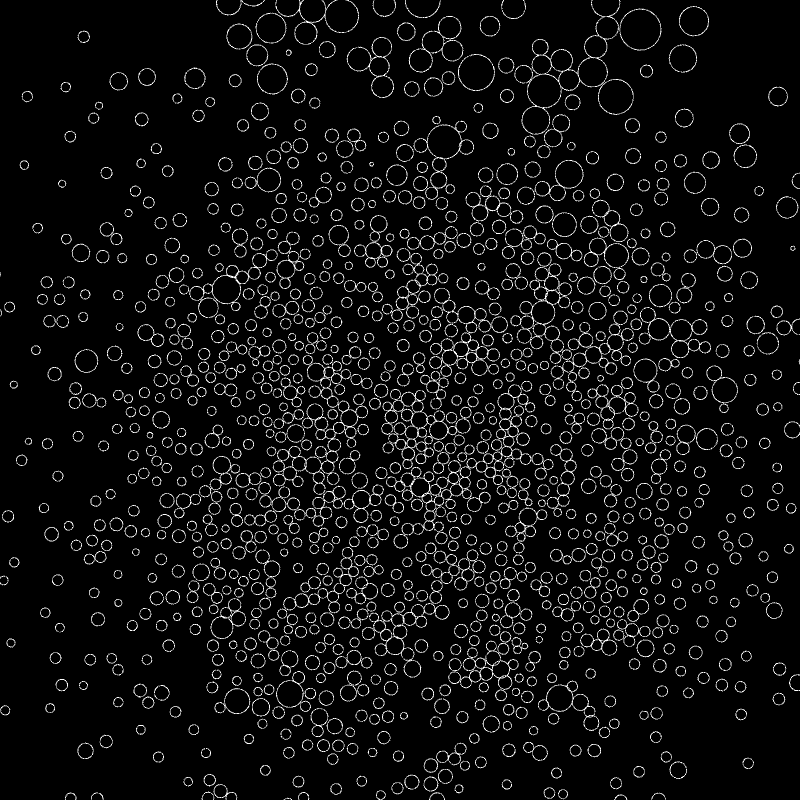

100%|██████████| 100/100 [00:04<00:00, 23.79it/s]

big_rad_loss 93898462461952.0
overlap_loss 176843936235520.0
distance_loss -15521936.0
out_of_bounds_loss 977350.5
loss 270742373531648.0


In [2562]:

display_freq=10
for ii in tqdm(range(100)):
    losses, scaled_losses, cc = train(
        loss_weights = {
            'big_rad_loss': 1e13,
            'overlap_loss': 1e9,
            'distance_loss': -1e-4,
            'out_of_bounds_loss': 1e0,
                
            }
    )
    if ii % display_freq == 0:
        
        display.clear_output(wait=True)
        img = render_circles(cc.to_circle_ps())
        fp = nft_dir.joinpath(f'{frame_counter:04d}.png')
        to_pil(img).save(fp)
        display.display(display.Image(fp))
        frame_counter += 1
        
for k,v in scaled_losses.items():
    print(k, float(v))

# img = render_circles(cc.to_circle_ps())
# to_pil(img)

In [2467]:
nft_dir

PosixPath('/home/naka/art/raster_videos/20220115-150952_169288-08f81-f7fd2a')

In [2563]:
filenames = sorted([fp.as_posix() for fp in nft_dir.glob('*.png')])

In [2564]:
import moviepy
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

In [2567]:
clipout = ImageSequenceClip(filenames, fps=30)
clipout.write_videofile(nft_dir.joinpath(f'{nft_id}.mp4').as_posix())

t:   0%|          | 0/701 [00:00<?, ?it/s, now=None]

Moviepy - Building video /home/naka/art/raster_videos/20220115-152135_807294-08f81-a0a461/20220115-152135_807294-08f81-a0a461.mp4.
Moviepy - Writing video /home/naka/art/raster_videos/20220115-152135_807294-08f81-a0a461/20220115-152135_807294-08f81-a0a461.mp4



Moviepy - Done !
Moviepy - video ready /home/naka/art/raster_videos/20220115-152135_807294-08f81-a0a461/20220115-152135_807294-08f81-a0a461.mp4


In [2387]:
len(filenames)

550

In [1817]:
x = model.get_net_output()
model.get_xs(x).shape

torch.Size([1, 10])

In [1818]:
model.radius_outputs(x)

tensor([0.0000, 0.0000, 0.0592, 0.0312, 0.0000, 0.0079, 0.0069, 0.0367, 0.0115,
        0.0093], grad_fn=<ReluBackward0>)

In [1565]:
n_circles = 100
init_rad_range = (0.001,1)
init_x_range = (CANVAS_WIDTH*0.1, CANVAS_WIDTH*0.9)
init_y_range = (CANVAS_HEIGHT*0.1, CANVAS_HEIGHT*0.9)
xmin, xmax = init_x_range
ymin, ymax = init_y_range

net = nn.Sequential(
    nn.Linear(0, n_circles),
    nn.ReLU(),
    nn.LazyLinear(n_circles),
    nn.ReLU(),
    nn.LazyLinear(n_circles),
    nn.ReLU(),
)

xs = torch.rand(n_circles, 2) * (xmax - xmin) + xmin
ys = torch.rand(n_circles, 2) * (ymax - ymin) + ymin

centers = torch.cat([xs, ys], axis=1)
radii = torch.rand(n_circles) * (init_rad_range[1] - init_rad_range[0]) + init_rad_range[0]
colors = torch.ones((n_circles,4))
stroke_widths = torch.ones((n_circles,1)) * 1

cc = CircleCollection(centers=centers, radii=radii, stroke_widths=stroke_widths, colors=colors)

/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [1563]:
n_circles = 100
init_rad_range = (0.001,1)
init_x_range = (CANVAS_WIDTH*0.1, CANVAS_WIDTH*0.9)
init_y_range = (CANVAS_HEIGHT*0.1, CANVAS_HEIGHT*0.9)
xmin, xmax = init_x_range
ymin, ymax = init_y_range

xs = np.interp(np.random.rand(n_circles), [0, 1], init_x_range)
ys = np.interp(np.random.rand(n_circles), [0, 1], init_y_range)
centers = [(x, y) for x, y in zip(xs, ys)]
radii = np.interp(stats.beta(a=1, b=3).rvs(n_circles), (0, 1), init_rad_range)
colors = np.ones((n_circles,4))
stroke_widths = np.ones((n_circles,1)) * 1

cc = CircleCollection.from_arrays(centers=centers, radii=radii, stroke_widths=stroke_widths, colors=colors)

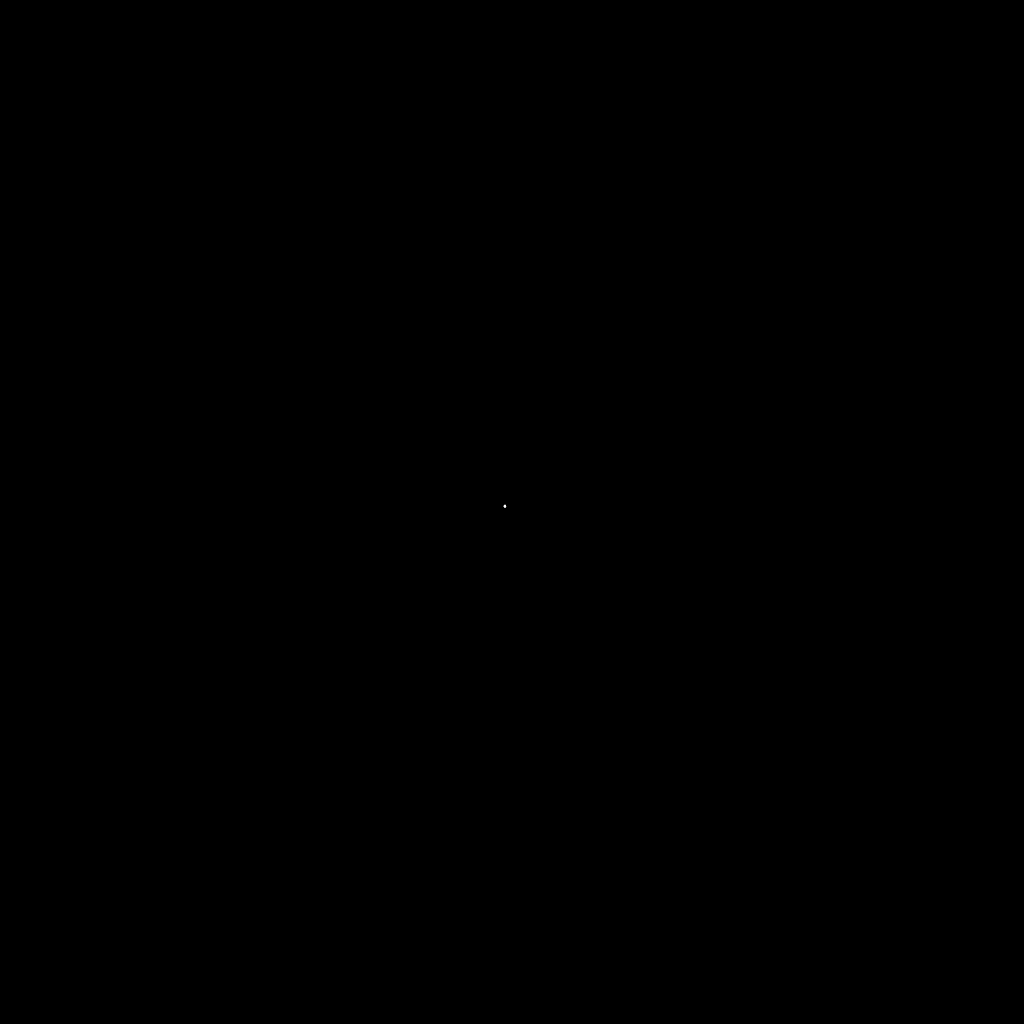

In [1612]:
img = render_circles(cc)
to_pil(img)


In [1441]:
def moment(t, n):
    return (((t - t.mean()) ** n).sum() / (t.std() ** n))

In [ ]:
n_steps = 100
for ii in tqdm(range(n_steps)):
    train()

100%|██████████| 100/100 [00:01<00:00, 54.65it/s]


In [503]:
F.relu

<function torch.nn.functional.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>

In [ ]:
optim = torch.optim.Adam([
    cc.centers, 
    cc.radii,
    ], lr=1e-1)

ValueError: can't optimize a non-leaf Tensor

/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/diffvg-0.0.1-py3.8-linux-x86_64.egg/pydiffvg/render_pytorch.py:136: Warning: Detected non-closed paths with fill color. This might causes unexpected results.
  warnings.warn("Detected non-closed paths with fill color. This might causes unexpected results.", Warning)


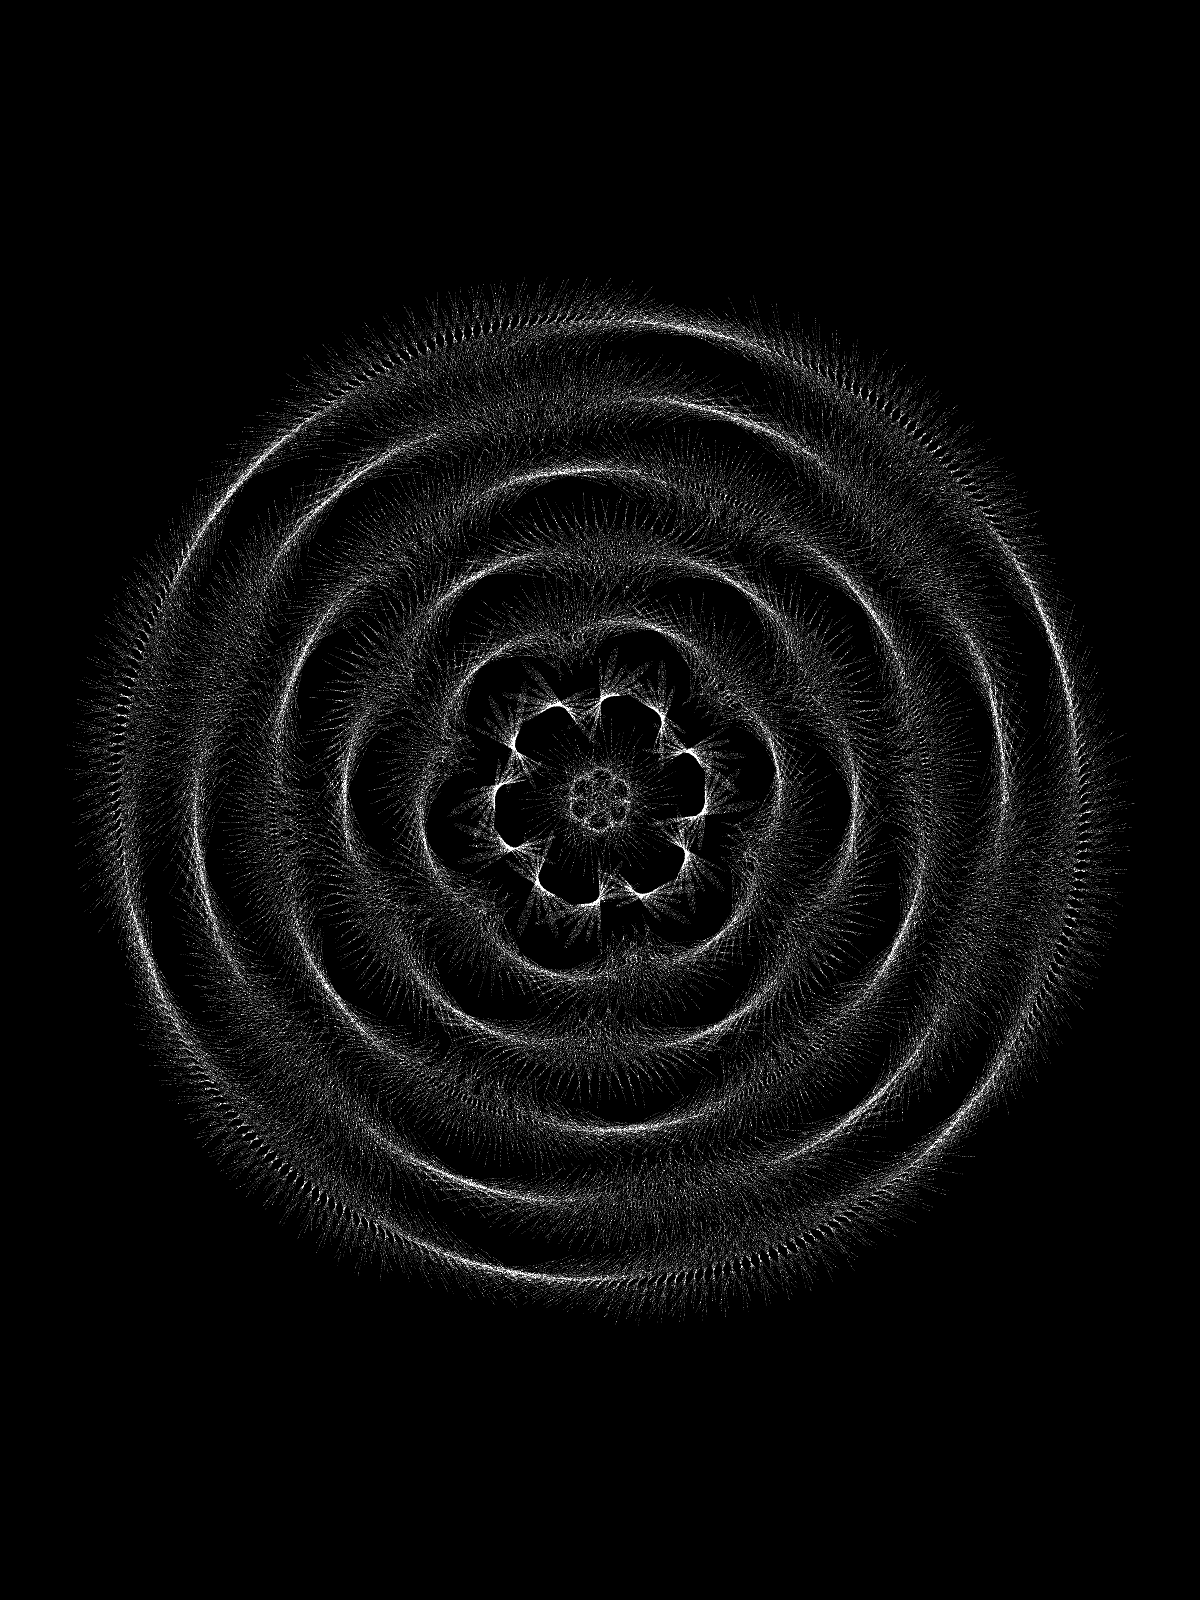

In [12]:
t=0.00
center = np.array(db.p.centroid.xy).ravel()
n_circles = 7
max_rad = (db.width/2) * 0.8
min_rad = (db.width/2) * 0.05
radii = np.linspace(min_rad, max_rad, n_circles)
loc_xy_spacing = 55
sls = []

for radius in radii:
    circumference = radius * 360
    angular_locs = np.arange(0, circumference, loc_xy_spacing) / radius
    for angular_loc_deg in angular_locs:
        rotation_deg = angular_loc_deg * 4 + 60 * np.sin(0.01 * angular_loc_deg * t + 0.02*radius) + np.sin(0.00013 * angular_loc_deg) * 20
        length = 8. + np.sin(radius * angular_loc_deg) * 90 + np.sin(angular_loc_deg*0.001) * 40 + np.sin(0.00013 * angular_loc_deg) * 70
        rad = radius + np.sin(t * angular_loc_deg) * 20
        sl = SpinLine(offset_xy=center, angular_loc_deg=angular_loc_deg, radial_loc=rad, rotation_deg=rotation_deg, length=length)
        sls.append(LineString(sl.coords))

gp.merge_LineStrings(sls)

lts = [LineTensor(ls) for ls in sls]

canvas_width, canvas_height = width, height
num_control_points = torch.tensor([0])
shapes = []
shape_groups = []
for ii, lt in enumerate(lts):
    path = dg.Path(num_control_points = num_control_points,
                         points = lt.tensor,
                         is_closed = False,
                         stroke_width = torch.tensor(0.1))
    shapes.append(path)
    path_group = dg.ShapeGroup(shape_ids = torch.tensor([ii]),
                                     fill_color = torch.tensor([0.0, 0.0, 0.0, 0.0]),
                                     stroke_color = torch.tensor([1., 1., 1., 1]))
    shape_groups.append(path_group)


scene_args = dg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
render = dg.RenderFunction.apply
img = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None, # background_image
             *scene_args)
# target = img.clone()

angle_targets = [torch.tensor(0) for shape in shapes]

# init
rendered_img = finalize_image(img.cpu(), as_Image=True)

img = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None, # background_image
             *scene_args)
img = finalize_image(img.cpu(), as_Image=True)


background = Image.new('RGBA', img.size, (0, 0, 0))

alpha_composite = Image.alpha_composite(background, img)
alpha_composite

In [ ]:
quality_val = 100
now = fn.get_time()
filepath = nft_dir.joinpath(f'{nft_id}_{now}_0000.jpeg')
alpha_composite.convert('RGB').save(filepath, quality=quality_val)